In [1]:
import pandas as pd
import numpy as np

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import numpy as np
import matplotlib as mpl

In [2]:
df = pd.read_parquet('./data/data_df_hcm.parquet')
target_df = pd.read_parquet('./data/target_df_hcm.parquet')

In [3]:
df

,nearest_5_district,nearest_8_street,nearest_2_ward,nearest_4_district,nearest_1_district,typeOfRealEstate,houseDirection,nearest_5_street,nearest_7_street,street,...,distance_hn_CongtruongLamSon,distance_hn_DuongNguyenHuequan1TPHCM,nearest_4_lat,num_of_atm_in_2000m_radius,num_of_place_of_worship_in_2000m_radius,num_of_restaurant_in_1000m_radius,numberOfBathRooms,distance_hn_DuongNamKyKhoiNghia,event_timestamp,realestate_id
24794,11,1730,13,11,11,3,0,857,756,253,...,7.647704,7.771465,10.790462,106,98,97,4.478184,7.835349,2023-04-01,24794
37176,10,2986,547,10,10,3,0,4053,3429,493,...,8.551525,8.572820,10.786360,35,72,15,4.478184,8.578963,2023-04-03,37176
6905,11,100,518,11,11,3,0,495,100,2252,...,7.143411,6.899570,10.766617,129,109,303,4.478184,6.688504,2023-05-18,6905
6412,10,3640,438,14,14,0,1,3062,1479,1551,...,8.428535,8.488024,10.803249,58,48,13,2.000000,8.519420,2023-07-13,6412
24436,18,1998,28,18,18,1,4,208,2642,219,...,8.776880,8.799135,10.799805,7,9,9,3.000000,8.820474,2023-07-14,24436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2697,1,357,116,1,1,1,0,3299,506,153,...,8.728899,8.680754,10.736959,9,2,3,2.000000,8.654018,2024-02-16,2697
22001,20,963,30,14,20,3,0,91,311,30,...,8.216211,8.298848,10.805246,57,55,15,5.000000,8.345146,2024-02-16,22001
21481,13,2268,399,13,13,1,7,2372,1469,2733,...,9.479880,9.503459,10.886026,3,1,0,1.000000,9.516926,2024-02-16,21481
10914,10,599,140,30,10,3,0,3708,3451,1047,...,8.967848,8.989615,10.805946,17,12,3,4.478184,8.998477,2024-02-16,10914


In [4]:
target_df.iloc[df[df['landSize'] == 45000].index.tolist()[0]]

target                           175.0
event_timestamp    2023-11-24 00:00:00
realestate_id                     5963
Name: 5963, dtype: object

In [5]:
df = df.reset_index(drop = True)
target_df = target_df.reset_index(drop = True)


In [6]:
check_df = pd.concat([df[['district', 'event_timestamp']], target_df[['target']]], axis = 1)

In [10]:
check_df.district.value_counts()

district
20    4691
10    4258
11    4007
33    2967
30    2952
1     2920
18    2695
14    2456
23    2262
32    2139
13    2016
15    1897
22    1851
0     1554
42     937
40     837
34     728
26     679
16     590
41     562
35     455
39     409
28     307
36      40
Name: count, dtype: int64

In [15]:
check_df = check_df[check_df['district'] == 20]
check_df

,district,event_timestamp,target
14,20,2023-09-20,73.529412
17,20,2023-09-30,189.565217
36,20,2023-10-18,118.421053
38,20,2023-10-19,106.250000
60,20,2023-10-26,187.500000
...,...,...,...
44169,20,2024-02-15,278.350515
44183,20,2024-02-15,136.923077
44184,20,2024-02-15,330.555556
44185,20,2024-02-15,212.064090


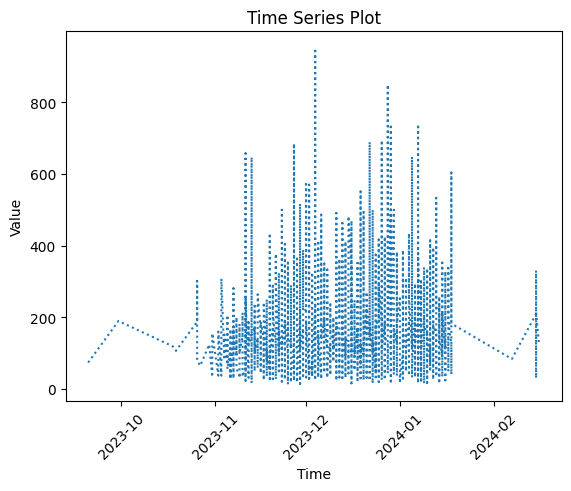

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

data = {'date_column': check_df['event_timestamp'], 'value_column': check_df['target']}
time_df = pd.DataFrame(data)

# Create the plot
plt.plot(time_df['date_column'], time_df['value_column'], linestyle = 'dotted')

# Add title and axis labels
plt.title('Time Series Plot')
plt.xlabel('Time')
plt.ylabel('Value')
plt.xticks(rotation=45)

# Display the plot
plt.show()

In [9]:
asdsad

NameError: name 'asdsad' is not defined

In [ ]:
import json

FS = json.load(open('./data/full_version.json', 'r'))
cat_cols = FS['cat_cols']
num_cols = FS['num_cols']
all_cols = cat_cols + num_cols

df = df[all_cols]

In [ ]:
categorical_features_indices = [i for i, c in enumerate(all_cols) if c in cat_cols]

In [ ]:
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
import random

def create_model(cat_idxs = None):
    if cat_idxs:
        model = CatBoostRegressor(cat_features=cat_idxs, iterations=5000, verbose = 100, random_state=random.randint(3, 1000), task_type='GPU', devices='0:1')
    else:
        model = CatBoostRegressor(iterations=5000, verbose = 100, random_state=random.randint(3, 1000), task_type='GPU', devices='0:1')
    search_params = {'learning_rate': [0.01, 0.08, 0.15]}
    clf = GridSearchCV(model, search_params, scoring=['explained_variance', 'max_error', 'neg_root_mean_squared_error', 'r2', 'neg_median_absolute_error', 'neg_mean_absolute_percentage_error'], refit='neg_root_mean_squared_error', cv=5)
    return clf

In [ ]:
model = create_model(categorical_features_indices)

In [ ]:
full_df = pd.concat([df, target_df['target']], axis = 1)

In [ ]:
full_df.shape

In [ ]:
train_df = full_df.iloc[:-35000]
test_df = full_df.iloc[-35000:]

In [ ]:
def train_test_split_by_col(train_df, test_df, X_cols, y_col):
    X_train, X_test, y_train, y_test = train_df[X_cols], test_df[X_cols], train_df[y_col], test_df[y_col]

    return X_train, X_test, np.log(y_train), np.log(y_test)


In [ ]:
target_feature = 'target'

In [ ]:
X_train, X_test, y_train, y_test = train_test_split_by_col(train_df = train_df, test_df = test_df, X_cols = all_cols, y_col = target_feature)
model.fit(X_train, y_train)

In [ ]:
model.predict(X_test)[:10]

In [ ]:
from joblib import dump, load

In [ ]:
estimator = model.best_estimator_
dump(estimator, "./model/hcm/cat/v2/model.joblib")

In [ ]:
load_model = load("./model/hcm/cat/v2/model.joblib")
load_model.predict(X_test)[:10]